Following Khomyakov's trouble-shooting tips in https://arxiv.org/pdf/cond-mat/0501609.pdf

In [1]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

from dataclasses import dataclass
import RGF_single_orbital as so
import RGFtools as rg
@dataclass
class JosephsonParameters:
    W : int
    L : int
    a : float
    t: float
    flux : float
    energy: float
    Delta: float
    phase: float
    mu: float
    tol: float
from scipy.linalg import orth

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
params = JosephsonParameters(W = 5 , 
                             L = 10,
                             t = 1,
                             a = 1 , 
                             flux = 0,
                             energy = 0,
                             Delta = 0,
                             phase = 0,
                             mu = 1.2,
                            tol = 1e-4)



In [25]:
def mode_sorting(eigenvalues , eigenvectors , params , slice):
    # each eigenvector is formed of amplitudes (c_{i} , c_{i-1}). We want the lower block:
    vectors = eigenvectors[int(eigenvectors.shape[0]/2) : , :]

    # We now want a matrix of norms. The column vectors in vectors may not necessarily be orthogonal but this is fine.
    norms = np.diagonal(np.conj(vectors.T) @ vectors)
    normalisation_factors = 1 / np.sqrt(norms)
    normalisation_factor_matrix = np.diag(normalisation_factors)

    normalised_vectors = vectors @ normalisation_factor_matrix

    # Eigenvalues corresponding to states that decay in the positive x direction:
    pos_e_evals = eigenvalues[(np.abs(eigenvalues) - 1) < -params.tol]
    # Eigenvalues corresponding to states that evanesce in the negative x direction:
    neg_e_evals = eigenvalues[(np.abs(eigenvalues) - 1) > params.tol]

    # Compute the group velocity for each state:
    group_velocities = np.zeros(vectors.shape[1])
    for i in range(vectors.shape[1]):
        group_velocities[i] = so.group_vel(normalised_vectors[: , i], eigenvalues[i] , slice , params)

    # Sorting propagating modes according to sign of group velocity:
    p_conditions = (np.abs((np.abs(eigenvalues) - 1)) <= params.tol) & (group_velocities > 0)
    n_conditions =(np.abs((np.abs(eigenvalues) - 1)) <= params.tol) & (group_velocities < 0 )

    pos_p_evals = eigenvalues[ p_conditions ]
    neg_p_evals = eigenvalues[ n_conditions]

    # Sorting normalised eigenvectors in the same way:
    pos_prop = normalised_vectors[: , p_conditions]
    neg_prop = normalised_vectors[: , n_conditions]

    pos_evanesce = normalised_vectors[: , (np.abs(eigenvalues) - 1) < -params.tol]
    neg_evanesce = normalised_vectors[: , (np.abs(eigenvalues) - 1) > params.tol]
    
    list_of_eigenvalues = [pos_p_evals , neg_p_evals , pos_e_evals , neg_e_evals]

    return pos_prop , neg_prop , pos_evanesce , neg_evanesce , list_of_eigenvalues , group_velocities
    
def generalised_eigenvalue_problem(slice , params):
    energy = params.energy
    M00 = np.linalg.inv(so.T(slice+1 , -1, params))@(energy*np.identity(params.W) -  so.h_0(slice , params)) # <- Calculating the Hamiltonian at slice.
    M01 = -np.linalg.inv(so.T(slice+1 , -1, params))@so.T(slice , +1 , params)
    M10 = np.identity(params.W)
    M11 = np.zeros(shape = (params.W , params.W))

    M = np.block([[M00 , M01],[M10 , M11]]) #<- Matrix to diagonalise for propagating modes in lead

    # evals are bloch factors, evecs are transverse mode eigenvfunctions for sites: (slice , slice -1)^{T}
    evals , evecs = np.linalg.eig(M)

    pos_prop , neg_prop , pos_evanesce , neg_evanesce , list_of_eigenvalues , gv = mode_sorting(evals , evecs ,params , slice)

    # Constructing U(±), matrices of right and left going eigenvectors:
    U_pos = np.hstack((pos_prop , pos_evanesce))
    U_neg = np.hstack((neg_prop , neg_evanesce))    
    
    # Constructing A(±) , diagonal matrix of bloch factors:
    Lambda_pos = np.diag(np.hstack((list_of_eigenvalues[0] ,list_of_eigenvalues[2])))
    Lambda_neg = np.diag(np.hstack((list_of_eigenvalues[1] , list_of_eigenvalues[3])))

    # Construct the F(\pm) transfer matrices:
    F_pos = U_pos @ Lambda_pos @ np.linalg.inv(U_pos)
    F_neg = U_neg @ Lambda_neg @ np.linalg.inv(U_neg)

        # This is for diagnostic purposes:
    debugdict = {'U_pos' : U_pos , 'U_neg' : U_neg , 'Lambda_pos' : Lambda_pos , 'Lambda_neg': Lambda_neg
                 , 'pos_prop' : pos_prop , 'neg_prop' : neg_prop , 'pos_evanesce' : pos_evanesce , 'neg_evanesce' : neg_evanesce
                 ,'list_of_eigenvalues' : list_of_eigenvalues , 'group_velocities' : gv, 'evals': evals , 'evecs': evecs}

    return F_pos , F_neg , debugdict

In [26]:
F_pos , F_neg , debug_dict = generalised_eigenvalue_problem(-1 , params)

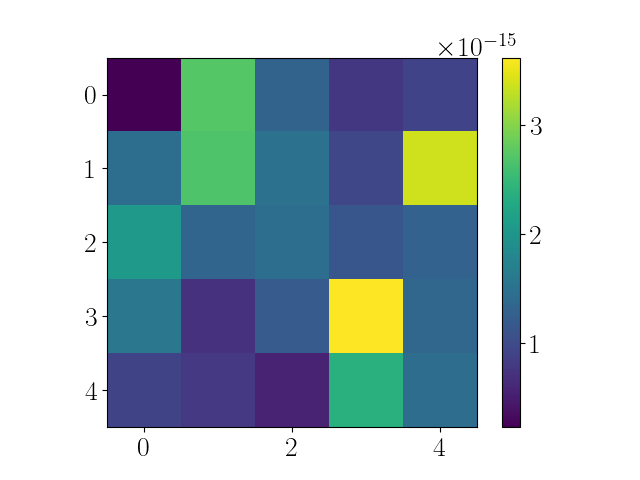

In [28]:
# Checking F_pos and F_neg satisfy the correct equation of motion:
matrix = ((params.energy*np.identity(params.W) - so.h_0(-1 , params)) - so.T(-1 + 1 , -1 , params)@F_neg 
          - so.T(-1 , +1 , params)@np.linalg.inv(F_neg))

plt.figure()
plt.imshow(np.abs(matrix))
plt.colorbar()